<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-qrf.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-qrf.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-qrf"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [ ]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

--2021-06-13 21:52:32--  https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pqenrr2mcvl0hk9/GEFCom2014.zip [following]
--2021-06-13 21:52:32--  https://www.dropbox.com/s/raw/pqenrr2mcvl0hk9/GEFCom2014.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5aa6c2ddc908dab78f3fe8997d.dl.dropboxusercontent.com/cd/0/inline/BQVlXAM3M8TmJYas8X22DyepGP4sol0wg_v2y_1F7h_PCKsEToQCjlGRw6Y_3v6v9_LJifd45hQd7UZzlaDfORZSDlvn3A-_8nXSuS7V-JElNWzN5EHzcx-Kk8BDUoq-1iUvY4XyIZhB01jLkMgO1LDE/file# [following]
--2021-06-13 21:52:33--  https://uc5aa6c2ddc908dab78f3fe8997d.dl.dropboxusercontent.com/cd/0/inline/BQVlXAM3M8TmJYas8X22DyepGP4sol0wg_v2y_1F7h_PCKsEToQCjlGRw6Y_3v6v9_LJifd45hQd7U

In [ ]:
!pip install doubt

# Select Task

In [ ]:
task = 5

# Prepare data

In [ ]:
import numpy as np
import pandas as pd

predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR164', 'VAR169', 'VAR175', 'VAR178', 'VAR228']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task+1}/train{task+1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)

#predictors['VAR164*169'] = predictors['VAR164'] * predictors['VAR169']

predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178', 'VAR228', 'VAR164'#, 'VAR164*169'
                        ]]
                             .rename({'VAR169': f'SSRD {i}',
                                      'VAR175': f'STRD {i}',
                                      'VAR178': f'TSR {i}', 
                                      'VAR228': f'TP {i}',
                                      'VAR164': f'TCC {i}'
                                      #'VAR164*169': f'TCC*SSRD {i}'
                                      }, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [ ]:
# decumulate data

from itertools import product

for name, zoneid in product(['SSRD', 'STRD', 'TSR'], range(1, 4)):
    subtract = predictor_data[f'{name} {zoneid}'].copy()
    subtract = subtract.shift()
    subtract.iloc[::24] = 0

    predictor_data[f'{name} {zoneid}'] -= subtract

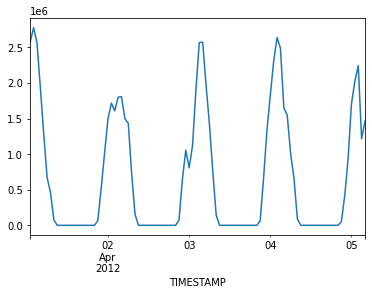

In [ ]:
predictor_data['SSRD 1'].iloc[:100].plot()

In [ ]:
gefcom14_metadata = {
    'num_series': 3,
    'num_steps': len(predictor_data),
    'prediction_length': len(benchmark) // 3,
    'start': predictor_data.index[0]
}

In [ ]:
for i in range(1, 4):
    predictor_data[f'SSRD {i}'] /= predictor_data[f'SSRD {i}'].max()
    predictor_data[f'STRD {i}'] /= predictor_data[f'STRD {i}'].max()
    predictor_data[f'TSR {i}'] /= predictor_data[f'TSR {i}'].max()
    #predictor_data[f'TP {i}'] /= predictor_data[f'TP {i}'].max()
    #predictor_data[f'TCC*SSRD {i}'] /= predictor_data[f'TCC*SSRD {i}'].max()

In [ ]:
predictor_zones = []
train_data_zones = []

for i in range(1, 4):
    predictor = predictor_data[[f'SSRD {i}', f'STRD {i}', f'TSR {i}', f'TP {i}', f'TCC {i}']]
    predictor_zones.append(predictor)
    train_data_zone = train_data[[f'ZONEID {i}']]
    train_data_zones.append(train_data_zone)

In [ ]:
x_input_zones = []
y_output_zones = []

for predictor, train_data in zip(predictor_zones, train_data_zones):
    x_input_df = predictor
    x_input = np.array(x_input_df)
    x_input_zones.append(x_input)
    y_output = np.array(train_data)
    y_output_zones.append(y_output)

# QRF

In [ ]:
from doubt import QuantileRegressionForest as QRF

qrf = QRF(max_leaf_nodes=8)

In [55]:
from tqdm import tqdm

prediction_zones = []

for zone in tqdm(range(1, 4)):
    x_train = x_input_zones[zone - 1][:-gefcom14_metadata['prediction_length']]
    x_test = x_input_zones[zone - 1][-gefcom14_metadata['prediction_length']:]
    y_train = np.squeeze(y_output_zones[zone - 1][:-gefcom14_metadata['prediction_length']])
    y_test = np.squeeze(y_output_zones[zone - 1][-gefcom14_metadata['prediction_length']:])

    qrf.fit(x_train, y_train)
    _, predictions = qrf.predict(x_test, quantiles=[p/100 for p in range(1, 100)])
    predictions_df = pd.DataFrame(predictions, columns=[p/100 for p in range(1, 100)])
    predictions_df.insert(loc=0, column='ZONEID', value=zone)
    prediction_zones.append(predictions_df)

100%|██████████| 3/3 [00:35<00:00, 11.89s/it]


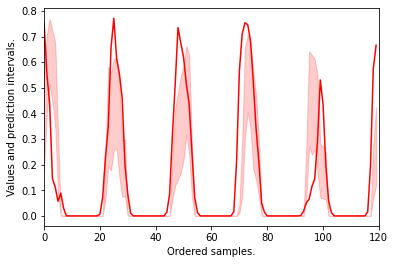

In [56]:
import matplotlib.pyplot as plt

lower = prediction_zones[0][0.2]
upper = prediction_zones[0][0.8]

plt.plot(y_output_zones[0][:5*24], "r")
plt.fill_between(
    np.arange(5*24), lower[:5*24], upper[:5*24], alpha=0.2, color="r",
    label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 5*24])
plt.show()

In [ ]:
!mkdir -p results

In [57]:
prediction = pd.concat(prediction_zones)
# prediction.to_csv(f'results/prediction_qrf_task{task}.csv')
prediction

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,1,0.046219,0.054170,0.062791,0.071968,0.081235,0.088833,0.095757,0.102973,0.109851,0.116955,0.123605,0.130805,0.137687,0.143814,0.150164,0.156370,0.161890,0.167636,0.173307,0.179060,0.184819,0.189855,0.195544,0.201487,0.207106,0.212208,0.217834,0.224287,0.230108,0.236194,0.241326,0.246741,0.252508,0.258424,0.263864,0.269197,0.274503,0.279432,0.284734,...,0.410543,0.418335,0.424918,0.432168,0.439022,0.446011,0.452708,0.459719,0.466543,0.473036,0.480300,0.488366,0.494751,0.502000,0.508447,0.515372,0.522730,0.529955,0.536292,0.544483,0.551286,0.558894,0.565816,0.574680,0.582810,0.591077,0.599913,0.607757,0.618061,0.627314,0.636929,0.646999,0.658509,0.670189,0.680797,0.693211,0.706525,0.721706,0.745018,0.781880
1,1,0.096336,0.131254,0.161210,0.183004,0.198948,0.212075,0.227893,0.243228,0.262195,0.280275,0.299276,0.317735,0.332379,0.344724,0.355852,0.368349,0.377067,0.384874,0.394894,0.404780,0.413225,0.421398,0.429563,0.437368,0.444404,0.452439,0.459606,0.466417,0.472862,0.479734,0.485782,0.492395,0.498596,0.504071,0.510828,0.516309,0.522147,0.526916,0.532490,...,0.637794,0.641749,0.646214,0.650235,0.653736,0.657488,0.661621,0.665139,0.668640,0.672164,0.675606,0.679495,0.682717,0.685750,0.688580,0.691975,0.694902,0.697596,0.700568,0.703710,0.707063,0.710289,0.713347,0.717042,0.721224,0.724907,0.728484,0.731949,0.736162,0.740002,0.744604,0.748242,0.753288,0.757996,0.763428,0.769264,0.775135,0.781862,0.793023,0.809561
2,1,0.165398,0.196880,0.225031,0.250580,0.276163,0.298419,0.323955,0.348335,0.374926,0.393037,0.410496,0.425363,0.437955,0.450744,0.460300,0.472084,0.482114,0.492400,0.501834,0.511588,0.521673,0.530701,0.541444,0.549453,0.558273,0.566043,0.572420,0.579252,0.584751,0.590564,0.595811,0.601392,0.607261,0.612317,0.616901,0.621618,0.626871,0.631473,0.636043,...,0.718750,0.721572,0.724055,0.726792,0.729269,0.731913,0.734761,0.737360,0.739488,0.742080,0.744631,0.747080,0.749549,0.751748,0.754077,0.756266,0.758564,0.761142,0.763507,0.766018,0.768622,0.771419,0.774150,0.777031,0.780059,0.782614,0.785162,0.787945,0.790926,0.794458,0.797890,0.801082,0.804908,0.809001,0.813109,0.817551,0.822122,0.828344,0.836213,0.850836
3,1,0.111469,0.152089,0.187941,0.213852,0.233236,0.248686,0.266502,0.282067,0.303717,0.325350,0.345331,0.364370,0.378626,0.391556,0.402649,0.414471,0.423147,0.430478,0.439754,0.448627,0.456773,0.465449,0.473045,0.480633,0.487881,0.495494,0.502762,0.510028,0.517533,0.524600,0.530094,0.536643,0.542715,0.547662,0.553077,0.558391,0.563622,0.568067,0.573360,...,0.666888,0.670484,0.674071,0.677373,0.680474,0.683219,0.686327,0.689223,0.691871,0.694757,0.697463,0.700776,0.703518,0.705876,0.708296,0.710902,0.713303,0.715804,0.718447,0.720711,0.723203,0.725744,0.728142,0.730868,0.733939,0.737112,0.740096,0.742981,0.746140,0.749516,0.753163,0.755863,0.759868,0.764405,0.769114,0.774418,0.779811,0.786524,0.797607,0.811734
4,1,0.075275,0.103649,0.127678,0.151273,0.167739,0.180467,0.195524,0.208406,0.223068,0.239482,0.254778,0.270550,0.282887,0.292744,0.302681,0.310852,0.318852,0.325934,0.335723,0.344637,0.352974,0.361064,0.367615,0.375374,0.384304,0.391305,0.399995,0.409437,0.419083,0.426982,0.432740,0.438899,0.445075,0.450780,0.456041,0.461390,0.466329,0.470548,0.475419,...,0.595139,0.601717,0.606732,0.612147,0.617613,0.622087,0.627270,0.631633,0.636119,0.640676,0.644499,0.649209,0.653589,0.656850,0.660101,0.662780,0.665282,0.668178,0.671285,0.674024,0.676582,0.679385,0.682117,0.684895,0.687529,0.690668,0.694360,0.697923,0.702371,0.705674,0.709439,0.712808,0.717475,0.721574,0.725596,0.731289,0.735909,0.742297,0.755403,0.773852
...,.

# Plotting the quantile prediction for the first entries

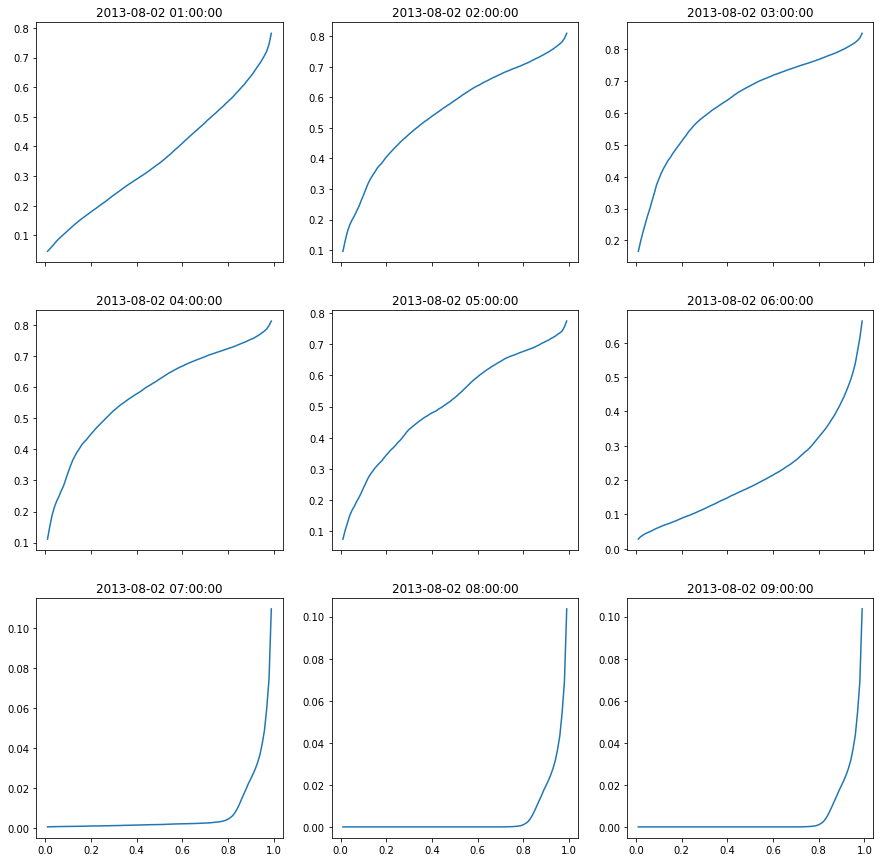

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    prediction.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3],
                                     title=str(predictor_zones[0][-24*30:].index[i]))

# Evaluate Loss

The loss function is the pinnball loss:
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [59]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction,
                    (1 - percentiles / 100) * (prediction - actual),
                    percentiles / 100 * (actual - prediction))
    return loss


test_ts1 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts2 = np.squeeze(train_data_zones[1][-gefcom14_metadata['prediction_length']:].values)
test_ts3 = np.squeeze(train_data_zones[2][-gefcom14_metadata['prediction_length']:].values)

prediction1 = prediction[prediction['ZONEID'] == 1].drop(columns='ZONEID')
prediction2 = prediction[prediction['ZONEID'] == 2].drop(columns='ZONEID')
prediction3 = prediction[prediction['ZONEID'] == 3].drop(columns='ZONEID')

loss1 = np.mean(pinnball_loss(test_ts1, prediction1))
loss2 = np.mean(pinnball_loss(test_ts2, prediction2))
loss3 = np.mean(pinnball_loss(test_ts3, prediction3))

loss = (loss1 + loss2 + loss3) / 3

print(f"Loss of task {task} with NNQF: {round(loss, 5)}")

Loss of task 5 with NNQF: 0.02087
